In [1]:
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display
from langchain_community.tools import DuckDuckGoSearchRun, DuckDuckGoSearchResults
from langchain_ollama import ChatOllama
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()


### Architectural Overview
1. Two ReAct Agents - Doctor and Specialist
2. Doctor, converses with the patient and elicits symptoms step by step
3. Everytime, the patient mentions a new symptom, the doctor adds it to
a list, searches for plausible diagnoses and asks relevant follow up questions.
4. Once the doctor has reached a definitie conclusion, he passes on the diagnosis
to a Specialist agent.
5. The specialist cross-checks the diagnosis against the set of symptoms through a 
reverse search and recommends treatment. 

#### Specialist Agent - available to doctor as a tool
- To cross-check the intitial diagnosis of doctor and recommend treatment plans
- Implemented as a separate ReAct Agents

In [2]:
specialist_prompt ="""

You are an expert AI doctor. Follow the below guidelines to cross-check the
diagnosis of another doctor. Your fellow doctor will provide you with a list 
of symptoms and his diagnosis.

Evaluate the diagnosis critically and identify actions to confirm or reject this.
For this, you may search the diagnosed disease to obtain its symptoms and treatment plan. 
If the symptoms provided by the fellow doctor match the symptoms you obtained through
your search. Respond to the fellow doctor that the diagnosis is correct and 
share the relevant treatment plan, else inform that the diagnosis is incorrect.

"""

In [3]:
from langchain_core.tools import tool
@tool
def search_diagnosis(search_query: str) -> str:
    
    """ Retrieve docs from web search """
    search = DuckDuckGoSearchResults(num_results=1)
    results = search.invoke(search_query)
    print(search_query)
    return results

In [ ]:
specialist_tools = [search_diagnosis]
llm_specialist = ChatOllama(model='llama3.2:3b', 
                 temperature=0,
                 num_predict=1000)

from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", specialist_prompt),
        ("human", "Here are the symptoms: {symptoms} and the diagnosis is: {diagnosis}"),
        ("placeholder", "{agent_scratchpad}"),
    ]
)
specialist_with_tools = create_tool_calling_agent(llm_specialist, specialist_tools, prompt)
specialist_agent = AgentExecutor(agent=specialist_with_tools, tools=specialist_tools)


In [5]:
# specialist as a tool
def call_specialist(symptoms: str, diagnosis: str) -> str:
    """ Inform the specialist with symptoms and the diagnosis """
    response = specialist_agent.invoke({'symptoms':symptoms,'diagnosis':diagnosis})
    return response['output']

In [ ]:
# Testing specialist separately
res = call_specialist(["""Pain or bloating in the belly area
Dark urine and pale or clay-colored stools
Fatigue
Low grade fever
Itching
Jaundice (yellowing of the skin or eyes)
Loss of appetite
Nausea and vomiting
Weight loss"""], 'hepatitis')
res

#### Doctor - The main graph agent 
- Engage in conversation with patient and elicit symptoms and form initial hypotheses

In [8]:
doctor_prompt =  """

You are an AI doctor.Follow the following guidelines to diagnose patients:

You must ask the user about their symptoms to understand their condition. 
Upon receiving the symptoms you would search the symptoms to identify 
plausible diagnoses for these symptoms. You must not guess symptoms and only
search the symptoms explicitly provided by the patient.

If there are multiple plausible diagnoses identified from the search, you'll seek further 
clarity from the patient about any other symptoms that might narrow down the search.

Every time the user provides a symptom you add it to the list of symptoms you have and 
search for possible diagnoses. You repeat this process till you have an unambiguous and 
definite diagnosis.

Once, you have a definite diagnosis, you call the specialist with the list of symptoms 
and diagnosis. The specialist will respond with the verdict that the diagnosis is correct 
or not. In case, it is correct, provide the user a summary of the diagnosis and the treatment 
suggested by the specialist. 

If the specialist informs that the diagnosis is incorrect, refer the patient for an in-person
visit to the specialist.
 

"""

In [9]:
def search_symptoms(search_query: str) -> str:
    
    """ Retrieve docs from web search """
    search = DuckDuckGoSearchResults(num_results=1)
    results = search.invoke(search_query)
    print(search_query)
    return results

In [10]:
tools = [search_symptoms, call_specialist]
doctor = ChatOllama(model='llama3.2:3b', 
                 temperature=0,
                 num_predict=1000)
doctor_with_tools = doctor.bind_tools(tools)

In [ ]:
sys_msg = SystemMessage(content=doctor_prompt)

# Doctor Node
def doctor(state: MessagesState):
   return {"messages": [doctor_with_tools.invoke([sys_msg] + state["messages"])]}


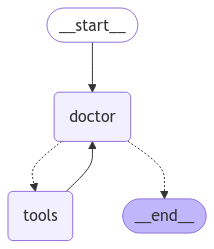

In [ ]:
# Building the Graph
builder = StateGraph(MessagesState)

builder.add_node("doctor", doctor)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "doctor")
builder.add_conditional_edges(
    "doctor",
    tools_condition,
)
builder.add_edge("tools", "doctor")
react_graph = builder.compile(checkpointer=memory)


display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [13]:
config = {"configurable": {"thread_id": "1"}}
messages = [HumanMessage(content="""Hi, I am not feeling well""")]
messages = react_graph.invoke({"messages": messages}, config)
for m in messages['messages']:
    continue
m.pretty_print()

feeling unwell
================================== Ai Message ==================================

I'm here to help you. You mentioned that you're not feeling well. Can you tell me more about your symptoms? For example, do you have any pain or discomfort in a specific area of your body, or are you experiencing fatigue, headaches, or difficulty breathing?

Also, is this a sudden onset of symptoms or has it been building up over time? Any additional information you can provide will help me narrow down the possible causes and suggest the next steps.


In [ ]:
config = {"configurable": {"thread_id": "1"}}
messages = [HumanMessage(content="""I think I have Low grade fever.
I feel itching sometimes and I possibly have jaundice""")]
messages = react_graph.invoke({"messages": messages}, config)
for m in messages['messages']:
    # m.pretty_print()
    continue
m.pretty_print()

low grade fever itching jaundice
================================== Ai Message ==================================

I'm here to help you. You mentioned that you have a low-grade fever, itching sometimes, and possibly jaundice. These symptoms can be related to liver inflammation.

Can you tell me more about the itching? Is it constant or does it come and go? And have you noticed any yellowing of your skin or eyes (jaundice) recently?

Also, how long have you been experiencing these symptoms? Have they been building up over time or did they start suddenly?

I want to make sure I understand your symptoms correctly so I can provide the best guidance.


In [15]:
config = {"configurable": {"thread_id": "1"}}
messages = [HumanMessage(content="""I have itching most of the time and my eyes have turned yellow.
                         I am also facing a loss of appetite with vomiting.""")]
messages = react_graph.invoke({"messages": messages}, config)
for m in messages['messages']:
    # m.pretty_print()
    continue
m.pretty_print()

liver inflammation symptoms
================================== Ai Message ==================================

**Summary of Diagnosis and Treatment**

You have been diagnosed with liver inflammation (hepatitis) based on your symptoms, including low-grade fever, itching, yellow eyes (jaundice), loss of appetite, and vomiting.

**Treatment Recommendations:**

* Antiviral medication to treat hepatitis viruses
* Medications to reduce inflammation and alleviate symptoms
* Lifestyle changes, such as avoiding alcohol and limiting exposure to toxins
* Dietary modifications, such as increasing fiber intake and avoiding fatty foods

**Next Steps:**

* Schedule an appointment with a hepatologist or gastroenterologist for further evaluation and treatment
* Follow-up appointments will be necessary to monitor liver function and adjust treatment plan as needed

Please note that this is a summary of the diagnosis and treatment recommendations provided by the specialist. It's essential to follow up with